In [12]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, platform, os
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import camb
from camb import model, initialpower

In [13]:
def kzps_old(mnu_in, sigma12_in=1):
    """
    Returns the scale axis, redshifts, power spectrum, and sigma12
    of a Lambda-CDM model
    @param mnu : neutrino mass
    @param sigma12 : if the spectrum should be rescaled,
        this parameter determines the sigma12 of the model
        
    warning: this function currently supports only one redshift,
        z = 0. This is not for difficulty of implementation,
        but only to make absolutely sure that our toy example
        is simple until we've understood the basics.
    """
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=mnu_in, omk=0, tau=0.06)
    pars.InitPower.set_params(As = 2e-09, ns=0.965)
    pars.set_matter_power(redshifts=[0.], kmax=2.0)
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    results.calc_power_spectra(pars)
    
    if sigma12_in != 1:
        omnuh2_leftover = 0
        if mnu_in == 0: # matter correction factor
            omnuh2_leftover = pars.omnuh2

        sigma12_unmodified = results.get_sigmaR(12, hubble_units=False)
        As_rescaled = 2e-9 * (sigma12_in / sigma12_unmodified) ** 2

        pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122 + omnuh2_leftover,
            mnu=mnu_in, omk=0, tau=0.06)
        pars.InitPower.set_params(As = As_rescaled, ns=0.965)
        pars.set_matter_power(redshifts=[0.], kmax=2.0)
        pars.NonLinear = model.NonLinear_none
        results = camb.get_results(pars)
        results.calc_power_spectra(pars)

    k, z, p = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)
    sigma12 = results.get_sigmaR(12, hubble_units=False)
    return k, z, p, sigma12

In [14]:
def kzps_new(mnu_in, sigma12_in=1, omch2_modifier=0):
    """
    Returns the scale axis, redshifts, power spectrum, and sigma12
    of a Lambda-CDM model
    @param mnu : neutrino mass
    @param sigma12 : if the spectrum should be rescaled,
        this parameter determines the sigma12 of the model
        
    warning: this function currently supports only one redshift,
        z = 0. This is not for difficulty of implementation,
        but only to make absolutely sure that our toy example
        is simple until we've understood the basics.
    """
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=mnu_in, omk=0, tau=0.06)
    pars.InitPower.set_params(As = 2e-09, ns=0.965)
    pars.set_matter_power(redshifts=[0.], kmax=2.0)
    pars.NonLinear = model.NonLinear_none
    results = camb.get_results(pars)
    results.calc_power_spectra(pars)
    
    if sigma12_in != 1:
        sigma12_unmodified = results.get_sigmaR(12, hubble_units=False)
        As_rescaled = 2e-9 * (sigma12_in / sigma12_unmodified) ** 2

        pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122 + omch2_modifier,
            mnu=mnu_in, omk=0, tau=0.06)
        pars.InitPower.set_params(As = As_rescaled, ns=0.965)
        pars.set_matter_power(redshifts=[0.], kmax=2.0)
        pars.NonLinear = model.NonLinear_none
        results = camb.get_results(pars)
        results.calc_power_spectra(pars)

    k, z, p = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)
    sigma12 = results.get_sigmaR(12, hubble_units=False)
    return k, z, p, sigma12, pars.omnuh2

In [16]:
massive = []
massless_new = []
massless_old = []

mnu_start = 0.06
mstep = 0.02
for i in range(0, 4):
    msum = mnu_start + mstep * i
    label = r"$\Sigma m_\nu = $" + str(msum) + " [eV]"
    k, z, p, s, omnuh2 = kzps_new(msum, 1)
    massive.append((label, k, z, p, s))
    label0 = r"$\Sigma m_\nu = 0$ norm'd to " + str(msum)
    k0, z0, p0, s0, omnuh2_0 = kzps_new(0, s, omnuh2)
    massless_new.append((label0, k0, z0, p0, s0))
    label0 = r"$\Sigma m_\nu = 0$ norm'd to " + str(msum)
    k0, z0, p0, s0 = kzps_old(0, s)
    massless_old.append((label0, k0, z0, p0, s0))

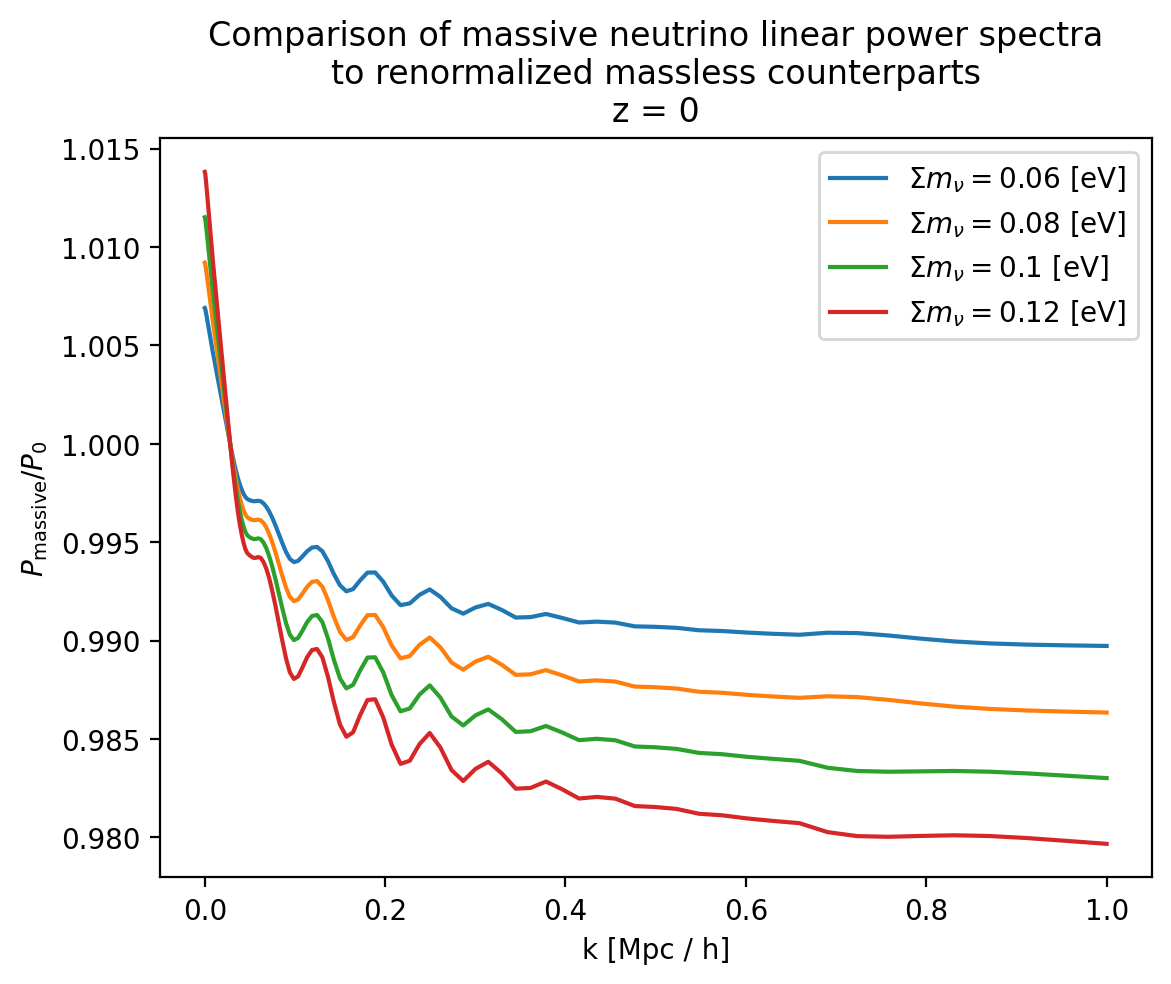

In [19]:
for i in range(len(massive)):
    y_new = massive[i][3][0] / massless_new[i][3][0]
    y_old = massive[i][3][0] / massless_old[i][3][0]
    plt.plot(massive[i][1], y_new / y_old, label=massive[i][0])

title = "Comparison of massive neutrino linear power spectra\n" + \
    "to renormalized massless counterparts\n" + \
    "z = 0"
plt.title(title)
plt.xlabel(r"k [Mpc / h]")
plt.ylabel(r"$P_\mathrm{massive} / P_0$")
plt.legend()

Ivanov 2021 ("Cosmological Constraints...") puts the limit at M_tot < 0.64 eV 95% CL.

Planck 2018 data apparently puts the limit at M_tot < 0.12 eV for 95% CL.

    This is cited in Amiri et al, 2021 ("Constraining neutrino mass...")

Font-Ribera et al. 2014 ("DESI and other...") puts the limit at M_tot > 0.06 eV.

In [18]:
y_new - y_old

array([ 1.44739629e-02,  1.44736928e-02,  1.44733172e-02,  1.44729102e-02,
        1.44725094e-02,  1.44720783e-02,  1.44715719e-02,  1.44709445e-02,
        1.44701675e-02,  1.44692934e-02,  1.44683890e-02,  1.44674701e-02,
        1.44665323e-02,  1.44655124e-02,  1.44643168e-02,  1.44629484e-02,
        1.44615042e-02,  1.44599967e-02,  1.44583449e-02,  1.44565005e-02,
        1.44544859e-02,  1.44522965e-02,  1.44498710e-02,  1.44471664e-02,
        1.44442532e-02,  1.44412060e-02,  1.44379039e-02,  1.44341674e-02,
        1.44299910e-02,  1.44254935e-02,  1.44207038e-02,  1.44155775e-02,
        1.44100230e-02,  1.44039365e-02,  1.43972665e-02,  1.43900867e-02,
        1.43824346e-02,  1.43742419e-02,  1.43654155e-02,  1.43558614e-02,
        1.43455015e-02,  1.43343097e-02,  1.43222857e-02,  1.43094129e-02,
        1.42956904e-02,  1.42810406e-02,  1.42653506e-02,  1.42485296e-02,
        1.42305620e-02,  1.42114064e-02,  1.41910357e-02,  1.41693553e-02,
        1.41461574e-02,  